## Objective

    OK - Open each image, split it in 4x4. 
    OK - Use find_voids to count number of voids in it.
    WIP- Colorize grains (1)
    4 - If voids>0 
            Recontruct boundaries
            Colorize after reconstruction (2)
        Else
            Copy (1)

    5 - Save (1) and (2) as train dataset



### Open images and split in 16


In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill
import cv2
from matplotlib import pyplot as plt

import find_voids as fv


In [2]:

folder = "../data/"
file = "1_005"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [21]:

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

N = width//4
M = height//4

full_img = np.zeros([height, width, 3])

for idx, row in df.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))    
    rr,cc= draw.line(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    full_img[cc,rr,:3] = (1,1,1)

tiles = [full_img[x:x+M,y:y+N] for x in range(0,full_img.shape[0],M) for y in range(0,full_img.shape[1],N)]



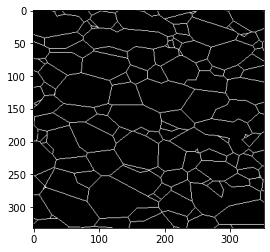

In [22]:
plt.imshow(tiles[15])

In [5]:
len(tiles)

16

### Creating tiles from original image and detecting voids

The program has detected 3 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 2 voids
The program has detected 4 voids
The program has detected 2 voids
The program has detected 5 voids
The program has detected 5 voids
The program has detected 1 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 0 voids
The program has detected 1 voids
The program has detected 1 voids
The program has detected 0 voids


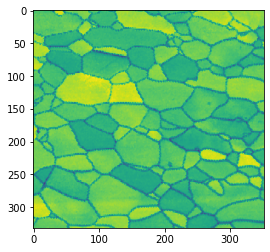

In [18]:

grey_img = cv2.imread(path+ '.jpg', 0)
grey_img = cv2.resize(gb_img,(width,height),interpolation = cv2.INTER_AREA)

tiles_grey = [grey_img[x:x+M,y:y+N] for x in range(0,grey_img.shape[0],M) for y in range(0,grey_img.shape[1],N)]

for tile in tiles_grey:
    centers, radii, vheight, image, drawing = fv.find_voids_2(tile)
    plt.imshow(tile)